Library

In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# ---------------------------------------
# 1. Data Loading and Inspection
# ---------------------------------------
train_data = pd.read_csv('/content/Google_Stock_Price_Train.csv')
test_data = pd.read_csv('/content/Google_Stock_Price_Test.csv')

print("Training Data Sample:\n", train_data.head())
print("Test Data Sample:\n", test_data.head())
print("Missing values in training data:\n", train_data.isnull().sum())

Training Data Sample:
        Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800
Test Data Sample:
        Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400
Missing values in training data:
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [ ]:
# ---------------------------------------
# 2. Data Cleaning and Preprocessing
# ---------------------------------------
features = ['Open', 'High', 'Low', 'Close']

for feature in features:
    if train_data[feature].dtype == 'object':
        train_data[feature] = train_data[feature].str.replace(',', '', regex=True).astype(float)
    if test_data[feature].dtype == 'object':
        test_data[feature] = test_data[feature].str.replace(',', '', regex=True).astype(float)

training_set = train_data[features].values
test_set = test_data[features].values

scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scaler.fit_transform(training_set)

In [ ]:
# ---------------------------------------
# 3. Fixed-length Sequence Creation (Sliding Window)
# ---------------------------------------
N = 30  # Past N days used as input
M = 1   # Predict next M days

X, y = [], []
for i in range(N, len(training_set_scaled) - M + 1):
    X.append(training_set_scaled[i-N:i, :])
    y.append(training_set_scaled[i:i+M, :])

X, y = np.array(X), np.array(y)

split = int(len(X) * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]


In [ ]:
# ---------------------------------------
# 4. Dataset and DataLoader
# ---------------------------------------
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(X_train, y_train)
val_dataset = StockDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# ---------------------------------------
# 5. Vanilla RNN Model
# ---------------------------------------
class VanillaRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(VanillaRNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


In [ ]:
# ---------------------------------------
# 6. Custom Asymmetric Loss Function
#    This loss penalizes underestimation more than overestimation.
# ---------------------------------------
class AsymmetricLoss(nn.Module):
    def __init__(self, ratio=2.0):
        super(AsymmetricLoss, self).__init__()
        self.ratio = ratio

    def forward(self, pred, target):
        diff = target - pred
        loss = torch.mean(torch.where(diff > 0, self.ratio * diff**2, diff**2))
        return loss

In [ ]:
# ---------------------------------------
# 7. Training Function with Metric Logging
#    We'll store train/val losses for plotting later.
# ---------------------------------------
def train_and_validate(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=30):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_state = None

    for epoch in range(epochs):
        # Training
        model.train()
        running_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.view(outputs.shape))
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.view(outputs.shape))
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return best_state, best_val_loss, train_losses, val_losses

In [ ]:
# ---------------------------------------
# 8. Hyperparameter Tuning with Optuna
# ---------------------------------------
def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 20, 100)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    ratio = trial.suggest_float('asymmetric_ratio', 1.0, 5.0)

    model = VanillaRNN(input_dim=len(features), hidden_dim=hidden_dim, output_dim=len(features)).to(device)
    criterion = AsymmetricLoss(ratio=ratio)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)

    # For the sake of tuning speed, use fewer epochs
    best_state, best_val_loss, _, _ = train_and_validate(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=30)
    return best_val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_params)

[I 2024-12-06 21:56:08,605] A new study created in memory with name: no-name-2984aaa3-ceda-4d02-86cb-f044568352c5


Epoch 1/30, Train Loss: 0.9395, Val Loss: 2.3349
Epoch 2/30, Train Loss: 0.5904, Val Loss: 1.5306
Epoch 3/30, Train Loss: 0.2280, Val Loss: 0.5530
Epoch 4/30, Train Loss: 0.0927, Val Loss: 0.2769
Epoch 5/30, Train Loss: 0.0966, Val Loss: 0.2719
Epoch 6/30, Train Loss: 0.0900, Val Loss: 0.2524
Epoch 7/30, Train Loss: 0.0849, Val Loss: 0.2349
Epoch 8/30, Train Loss: 0.0794, Val Loss: 0.2155
Epoch 9/30, Train Loss: 0.0740, Val Loss: 0.1956
Epoch 10/30, Train Loss: 0.0685, Val Loss: 0.1754
Epoch 11/30, Train Loss: 0.0631, Val Loss: 0.1553
Epoch 12/30, Train Loss: 0.0577, Val Loss: 0.1355
Epoch 13/30, Train Loss: 0.0525, Val Loss: 0.1163
Epoch 14/30, Train Loss: 0.0476, Val Loss: 0.0981
Epoch 15/30, Train Loss: 0.0430, Val Loss: 0.0814
Epoch 16/30, Train Loss: 0.0388, Val Loss: 0.0668
Epoch 17/30, Train Loss: 0.0354, Val Loss: 0.0558
Epoch 18/30, Train Loss: 0.0326, Val Loss: 0.0483
Epoch 19/30, Train Loss: 0.0297, Val Loss: 0.0409
Epoch 20/30, Train Loss: 0.0270, Val Loss: 0.0344
Epoch 21/

[I 2024-12-06 21:56:20,224] Trial 0 finished with value: 0.01052901556249708 and parameters: {'hidden_dim': 76, 'lr': 0.00012924869008607318, 'weight_decay': 1.9293300019011397e-05, 'asymmetric_ratio': 4.938901017604606}. Best is trial 0 with value: 0.01052901556249708.


Epoch 30/30, Train Loss: 0.0047, Val Loss: 0.0105
Epoch 1/30, Train Loss: 0.0861, Val Loss: 0.1534
Epoch 2/30, Train Loss: 0.0951, Val Loss: 0.0847
Epoch 3/30, Train Loss: 0.0642, Val Loss: 0.0499
Epoch 4/30, Train Loss: 0.0471, Val Loss: 0.0286
Epoch 5/30, Train Loss: 0.0299, Val Loss: 0.0157
Epoch 6/30, Train Loss: 0.0232, Val Loss: 0.0072
Epoch 7/30, Train Loss: 0.0174, Val Loss: 0.0031
Epoch 8/30, Train Loss: 0.0167, Val Loss: 0.0092
Epoch 9/30, Train Loss: 0.0164, Val Loss: 0.0014
Epoch 10/30, Train Loss: 0.0151, Val Loss: 0.0238
Epoch 11/30, Train Loss: 0.0064, Val Loss: 0.0018
Epoch 12/30, Train Loss: 0.0036, Val Loss: 0.0009
Epoch 13/30, Train Loss: 0.0038, Val Loss: 0.0061
Epoch 14/30, Train Loss: 0.0033, Val Loss: 0.0050
Epoch 15/30, Train Loss: 0.0040, Val Loss: 0.0055
Epoch 16/30, Train Loss: 0.0061, Val Loss: 0.0117
Epoch 17/30, Train Loss: 0.0048, Val Loss: 0.0011
Epoch 18/30, Train Loss: 0.0014, Val Loss: 0.0010
Epoch 19/30, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 20/

[I 2024-12-06 21:56:30,349] Trial 1 finished with value: 0.0008819270624371711 and parameters: {'hidden_dim': 51, 'lr': 0.0009761084715351154, 'weight_decay': 2.0727013250110027e-05, 'asymmetric_ratio': 2.7666356784287505}. Best is trial 1 with value: 0.0008819270624371711.


Epoch 29/30, Train Loss: 0.0010, Val Loss: 0.0015
Epoch 30/30, Train Loss: 0.0010, Val Loss: 0.0015
Epoch 1/30, Train Loss: 0.0331, Val Loss: 0.0532
Epoch 2/30, Train Loss: 0.2710, Val Loss: 0.0499
Epoch 3/30, Train Loss: 0.1034, Val Loss: 0.0278
Epoch 4/30, Train Loss: 0.1133, Val Loss: 0.0111
Epoch 5/30, Train Loss: 0.0519, Val Loss: 0.0416
Epoch 6/30, Train Loss: 0.0662, Val Loss: 0.0052
Epoch 7/30, Train Loss: 0.0636, Val Loss: 0.0100
Epoch 8/30, Train Loss: 0.0339, Val Loss: 0.0207
Epoch 9/30, Train Loss: 0.0170, Val Loss: 0.0057
Epoch 10/30, Train Loss: 0.0122, Val Loss: 0.0082
Epoch 11/30, Train Loss: 0.0103, Val Loss: 0.0048
Epoch 12/30, Train Loss: 0.0045, Val Loss: 0.0049
Epoch 13/30, Train Loss: 0.0030, Val Loss: 0.0049
Epoch 14/30, Train Loss: 0.0022, Val Loss: 0.0036
Epoch 15/30, Train Loss: 0.0018, Val Loss: 0.0029
Epoch 16/30, Train Loss: 0.0015, Val Loss: 0.0023
Epoch 17/30, Train Loss: 0.0013, Val Loss: 0.0018
Epoch 18/30, Train Loss: 0.0011, Val Loss: 0.0014
Epoch 19/

[I 2024-12-06 21:56:36,962] Trial 2 finished with value: 0.0005871900903002825 and parameters: {'hidden_dim': 80, 'lr': 0.0059537961929750985, 'weight_decay': 7.980312644042782e-06, 'asymmetric_ratio': 4.396507621404423}. Best is trial 2 with value: 0.0005871900903002825.


Epoch 30/30, Train Loss: 0.0008, Val Loss: 0.0006
Epoch 1/30, Train Loss: 0.0367, Val Loss: 0.0350
Epoch 2/30, Train Loss: 0.0641, Val Loss: 0.0261
Epoch 3/30, Train Loss: 0.0599, Val Loss: 0.0212
Epoch 4/30, Train Loss: 0.0450, Val Loss: 0.0046
Epoch 5/30, Train Loss: 0.0412, Val Loss: 0.0048
Epoch 6/30, Train Loss: 0.0433, Val Loss: 0.0105
Epoch 7/30, Train Loss: 0.0235, Val Loss: 0.0067
Epoch 8/30, Train Loss: 0.0177, Val Loss: 0.0098
Epoch 9/30, Train Loss: 0.0101, Val Loss: 0.0036
Epoch 10/30, Train Loss: 0.0035, Val Loss: 0.0035
Epoch 11/30, Train Loss: 0.0021, Val Loss: 0.0038
Epoch 12/30, Train Loss: 0.0016, Val Loss: 0.0032
Epoch 13/30, Train Loss: 0.0013, Val Loss: 0.0026
Epoch 14/30, Train Loss: 0.0012, Val Loss: 0.0022
Epoch 15/30, Train Loss: 0.0011, Val Loss: 0.0019
Epoch 16/30, Train Loss: 0.0010, Val Loss: 0.0016
Epoch 17/30, Train Loss: 0.0009, Val Loss: 0.0015
Epoch 18/30, Train Loss: 0.0009, Val Loss: 0.0013
Epoch 19/30, Train Loss: 0.0008, Val Loss: 0.0012
Epoch 20/

[I 2024-12-06 21:56:42,573] Trial 3 finished with value: 0.0009206918657582719 and parameters: {'hidden_dim': 78, 'lr': 0.002271669704973335, 'weight_decay': 1.2799835787118121e-06, 'asymmetric_ratio': 2.395542577232243}. Best is trial 2 with value: 0.0005871900903002825.


Epoch 30/30, Train Loss: 0.0008, Val Loss: 0.0009
Epoch 1/30, Train Loss: 0.0378, Val Loss: 0.0051
Epoch 2/30, Train Loss: 0.0686, Val Loss: 0.0438
Epoch 3/30, Train Loss: 0.0871, Val Loss: 0.0127
Epoch 4/30, Train Loss: 0.0510, Val Loss: 0.0141
Epoch 5/30, Train Loss: 0.0617, Val Loss: 0.0168
Epoch 6/30, Train Loss: 0.0382, Val Loss: 0.0163
Epoch 7/30, Train Loss: 0.0253, Val Loss: 0.0217
Epoch 8/30, Train Loss: 0.0217, Val Loss: 0.0216
Epoch 9/30, Train Loss: 0.0194, Val Loss: 0.0202
Epoch 10/30, Train Loss: 0.0166, Val Loss: 0.0199
Epoch 11/30, Train Loss: 0.0164, Val Loss: 0.0197
Epoch 12/30, Train Loss: 0.0161, Val Loss: 0.0194
Epoch 13/30, Train Loss: 0.0159, Val Loss: 0.0191
Epoch 14/30, Train Loss: 0.0156, Val Loss: 0.0191
Epoch 15/30, Train Loss: 0.0156, Val Loss: 0.0191
Epoch 16/30, Train Loss: 0.0156, Val Loss: 0.0190
Epoch 17/30, Train Loss: 0.0156, Val Loss: 0.0190
Epoch 18/30, Train Loss: 0.0155, Val Loss: 0.0190
Epoch 19/30, Train Loss: 0.0155, Val Loss: 0.0190
Epoch 20/

[I 2024-12-06 21:56:48,129] Trial 4 finished with value: 0.005077613503090106 and parameters: {'hidden_dim': 23, 'lr': 0.009792389221187001, 'weight_decay': 3.585115644781039e-05, 'asymmetric_ratio': 4.857886216914608}. Best is trial 2 with value: 0.0005871900903002825.


Epoch 30/30, Train Loss: 0.0155, Val Loss: 0.0190
Epoch 1/30, Train Loss: 0.0738, Val Loss: 0.1918
Epoch 2/30, Train Loss: 0.1315, Val Loss: 0.0985
Epoch 3/30, Train Loss: 0.0840, Val Loss: 0.0504
Epoch 4/30, Train Loss: 0.0581, Val Loss: 0.0264
Epoch 5/30, Train Loss: 0.0403, Val Loss: 0.0112
Epoch 6/30, Train Loss: 0.0245, Val Loss: 0.0016
Epoch 7/30, Train Loss: 0.0251, Val Loss: 0.0054
Epoch 8/30, Train Loss: 0.0269, Val Loss: 0.0080
Epoch 9/30, Train Loss: 0.0108, Val Loss: 0.0034
Epoch 10/30, Train Loss: 0.0038, Val Loss: 0.0015
Epoch 11/30, Train Loss: 0.0099, Val Loss: 0.0119
Epoch 12/30, Train Loss: 0.0125, Val Loss: 0.0053
Epoch 13/30, Train Loss: 0.0090, Val Loss: 0.0091
Epoch 14/30, Train Loss: 0.0201, Val Loss: 0.0336
Epoch 15/30, Train Loss: 0.0062, Val Loss: 0.0188
Epoch 16/30, Train Loss: 0.0044, Val Loss: 0.0101
Epoch 17/30, Train Loss: 0.0038, Val Loss: 0.0070
Epoch 18/30, Train Loss: 0.0033, Val Loss: 0.0053
Epoch 19/30, Train Loss: 0.0029, Val Loss: 0.0052
Epoch 20/

[I 2024-12-06 21:56:54,027] Trial 5 finished with value: 0.0014900019887136295 and parameters: {'hidden_dim': 89, 'lr': 0.0006876933860979493, 'weight_decay': 0.0007143111944517515, 'asymmetric_ratio': 3.3556150892902825}. Best is trial 2 with value: 0.0005871900903002825.


Epoch 30/30, Train Loss: 0.0027, Val Loss: 0.0048
Epoch 1/30, Train Loss: 0.0465, Val Loss: 0.0573
Epoch 2/30, Train Loss: 0.0876, Val Loss: 0.0162
Epoch 3/30, Train Loss: 0.0780, Val Loss: 0.0014
Epoch 4/30, Train Loss: 0.0734, Val Loss: 0.0374
Epoch 5/30, Train Loss: 0.0422, Val Loss: 0.0068
Epoch 6/30, Train Loss: 0.0376, Val Loss: 0.0120
Epoch 7/30, Train Loss: 0.0394, Val Loss: 0.0124
Epoch 8/30, Train Loss: 0.0138, Val Loss: 0.0058
Epoch 9/30, Train Loss: 0.0088, Val Loss: 0.0028
Epoch 10/30, Train Loss: 0.0067, Val Loss: 0.0025
Epoch 11/30, Train Loss: 0.0053, Val Loss: 0.0021
Epoch 12/30, Train Loss: 0.0041, Val Loss: 0.0021
Epoch 13/30, Train Loss: 0.0040, Val Loss: 0.0021
Epoch 14/30, Train Loss: 0.0039, Val Loss: 0.0021
Epoch 15/30, Train Loss: 0.0038, Val Loss: 0.0021
Epoch 16/30, Train Loss: 0.0037, Val Loss: 0.0021
Epoch 17/30, Train Loss: 0.0037, Val Loss: 0.0021
Epoch 18/30, Train Loss: 0.0037, Val Loss: 0.0021
Epoch 19/30, Train Loss: 0.0037, Val Loss: 0.0021
Epoch 20/

[I 2024-12-06 21:56:59,470] Trial 6 finished with value: 0.0013937854455434717 and parameters: {'hidden_dim': 38, 'lr': 0.004085731032479867, 'weight_decay': 4.532131808062675e-06, 'asymmetric_ratio': 4.227314318299821}. Best is trial 2 with value: 0.0005871900903002825.


Epoch 30/30, Train Loss: 0.0037, Val Loss: 0.0021
Epoch 1/30, Train Loss: 0.0277, Val Loss: 0.0485
Epoch 2/30, Train Loss: 0.0521, Val Loss: 0.0225
Epoch 3/30, Train Loss: 0.1448, Val Loss: 0.0356
Epoch 4/30, Train Loss: 0.5103, Val Loss: 1.7128
Epoch 5/30, Train Loss: 0.1977, Val Loss: 0.1010
Epoch 6/30, Train Loss: 0.2035, Val Loss: 0.0267
Epoch 7/30, Train Loss: 0.1956, Val Loss: 0.1171
Epoch 8/30, Train Loss: 0.1552, Val Loss: 0.1396
Epoch 9/30, Train Loss: 0.1375, Val Loss: 0.1147
Epoch 10/30, Train Loss: 0.1329, Val Loss: 0.0990
Epoch 11/30, Train Loss: 0.1001, Val Loss: 0.1456
Epoch 12/30, Train Loss: 0.0871, Val Loss: 0.1999
Epoch 13/30, Train Loss: 0.0804, Val Loss: 0.2234
Epoch 14/30, Train Loss: 0.0781, Val Loss: 0.2289
Epoch 15/30, Train Loss: 0.0740, Val Loss: 0.2293
Epoch 16/30, Train Loss: 0.0739, Val Loss: 0.2299
Epoch 17/30, Train Loss: 0.0739, Val Loss: 0.2305
Epoch 18/30, Train Loss: 0.0738, Val Loss: 0.2310
Epoch 19/30, Train Loss: 0.0734, Val Loss: 0.2311
Epoch 20/

[I 2024-12-06 21:57:05,545] Trial 7 finished with value: 0.02248993027023971 and parameters: {'hidden_dim': 83, 'lr': 0.008792684240068863, 'weight_decay': 8.514125515525972e-06, 'asymmetric_ratio': 2.5561861227405185}. Best is trial 2 with value: 0.0005871900903002825.


Epoch 29/30, Train Loss: 0.0733, Val Loss: 0.2313
Epoch 30/30, Train Loss: 0.0733, Val Loss: 0.2313
Epoch 1/30, Train Loss: 0.0493, Val Loss: 0.0419
Epoch 2/30, Train Loss: 0.1191, Val Loss: 0.0088
Epoch 3/30, Train Loss: 0.1020, Val Loss: 0.0147
Epoch 4/30, Train Loss: 0.0617, Val Loss: 0.0157
Epoch 5/30, Train Loss: 0.0437, Val Loss: 0.0278
Epoch 6/30, Train Loss: 0.0398, Val Loss: 0.0218
Epoch 7/30, Train Loss: 0.0169, Val Loss: 0.0169
Epoch 8/30, Train Loss: 0.0121, Val Loss: 0.0116
Epoch 9/30, Train Loss: 0.0102, Val Loss: 0.0080
Epoch 10/30, Train Loss: 0.0086, Val Loss: 0.0062
Epoch 11/30, Train Loss: 0.0068, Val Loss: 0.0046
Epoch 12/30, Train Loss: 0.0051, Val Loss: 0.0031
Epoch 13/30, Train Loss: 0.0036, Val Loss: 0.0019
Epoch 14/30, Train Loss: 0.0024, Val Loss: 0.0012
Epoch 15/30, Train Loss: 0.0017, Val Loss: 0.0010
Epoch 16/30, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 17/30, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 18/30, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 19/

[I 2024-12-06 21:57:15,065] Trial 8 finished with value: 0.0009830861708906014 and parameters: {'hidden_dim': 92, 'lr': 0.0020595981023488292, 'weight_decay': 0.00047154136606007485, 'asymmetric_ratio': 4.478863682940213}. Best is trial 2 with value: 0.0005871900903002825.


Epoch 30/30, Train Loss: 0.0009, Val Loss: 0.0010
Epoch 1/30, Train Loss: 0.0298, Val Loss: 0.0280
Epoch 2/30, Train Loss: 0.2470, Val Loss: 0.0927
Epoch 3/30, Train Loss: 0.1992, Val Loss: 0.0376
Epoch 4/30, Train Loss: 0.2390, Val Loss: 0.0356
Epoch 5/30, Train Loss: 0.1349, Val Loss: 0.0480
Epoch 6/30, Train Loss: 0.1674, Val Loss: 0.0896
Epoch 7/30, Train Loss: 0.1300, Val Loss: 0.0638
Epoch 8/30, Train Loss: 0.0997, Val Loss: 0.0745
Epoch 9/30, Train Loss: 0.0976, Val Loss: 0.0919
Epoch 10/30, Train Loss: 0.0514, Val Loss: 0.0971
Epoch 11/30, Train Loss: 0.0493, Val Loss: 0.1094
Epoch 12/30, Train Loss: 0.0477, Val Loss: 0.1110
Epoch 13/30, Train Loss: 0.0470, Val Loss: 0.1111
Epoch 14/30, Train Loss: 0.0444, Val Loss: 0.1111
Epoch 15/30, Train Loss: 0.0444, Val Loss: 0.1112
Epoch 16/30, Train Loss: 0.0443, Val Loss: 0.1113
Epoch 17/30, Train Loss: 0.0443, Val Loss: 0.1113
Epoch 18/30, Train Loss: 0.0440, Val Loss: 0.1113
Epoch 19/30, Train Loss: 0.0440, Val Loss: 0.1113
Epoch 20/

[I 2024-12-06 21:57:22,666] Trial 9 finished with value: 0.027960188686847687 and parameters: {'hidden_dim': 67, 'lr': 0.007086953996360458, 'weight_decay': 3.9705386465595196e-05, 'asymmetric_ratio': 4.903836168719955}. Best is trial 2 with value: 0.0005871900903002825.


Epoch 29/30, Train Loss: 0.0440, Val Loss: 0.1113
Epoch 30/30, Train Loss: 0.0440, Val Loss: 0.1113
Epoch 1/30, Train Loss: 0.2565, Val Loss: 0.4749
Epoch 2/30, Train Loss: 0.0568, Val Loss: 0.0905
Epoch 3/30, Train Loss: 0.0516, Val Loss: 0.0864
Epoch 4/30, Train Loss: 0.0433, Val Loss: 0.0747
Epoch 5/30, Train Loss: 0.0384, Val Loss: 0.0623
Epoch 6/30, Train Loss: 0.0340, Val Loss: 0.0511
Epoch 7/30, Train Loss: 0.0296, Val Loss: 0.0406
Epoch 8/30, Train Loss: 0.0255, Val Loss: 0.0314
Epoch 9/30, Train Loss: 0.0218, Val Loss: 0.0242
Epoch 10/30, Train Loss: 0.0189, Val Loss: 0.0192
Epoch 11/30, Train Loss: 0.0169, Val Loss: 0.0166
Epoch 12/30, Train Loss: 0.0146, Val Loss: 0.0145
Epoch 13/30, Train Loss: 0.0117, Val Loss: 0.0132
Epoch 14/30, Train Loss: 0.0086, Val Loss: 0.0136
Epoch 15/30, Train Loss: 0.0061, Val Loss: 0.0127
Epoch 16/30, Train Loss: 0.0038, Val Loss: 0.0095
Epoch 17/30, Train Loss: 0.0027, Val Loss: 0.0076
Epoch 18/30, Train Loss: 0.0029, Val Loss: 0.0094
Epoch 19/

[I 2024-12-06 21:57:28,848] Trial 10 finished with value: 0.005123207607539371 and parameters: {'hidden_dim': 59, 'lr': 0.00024806852289884217, 'weight_decay': 0.00011054810750835488, 'asymmetric_ratio': 1.3243605235309506}. Best is trial 2 with value: 0.0005871900903002825.


Epoch 30/30, Train Loss: 0.0019, Val Loss: 0.0054
Epoch 1/30, Train Loss: 0.0781, Val Loss: 0.1517
Epoch 2/30, Train Loss: 0.1214, Val Loss: 0.0705
Epoch 3/30, Train Loss: 0.0877, Val Loss: 0.0803
Epoch 4/30, Train Loss: 0.0597, Val Loss: 0.0618
Epoch 5/30, Train Loss: 0.0437, Val Loss: 0.0356
Epoch 6/30, Train Loss: 0.0310, Val Loss: 0.0187
Epoch 7/30, Train Loss: 0.0245, Val Loss: 0.0117
Epoch 8/30, Train Loss: 0.0196, Val Loss: 0.0051
Epoch 9/30, Train Loss: 0.0120, Val Loss: 0.0114
Epoch 10/30, Train Loss: 0.0078, Val Loss: 0.0051
Epoch 11/30, Train Loss: 0.0066, Val Loss: 0.0090
Epoch 12/30, Train Loss: 0.0050, Val Loss: 0.0058
Epoch 13/30, Train Loss: 0.0101, Val Loss: 0.0192
Epoch 14/30, Train Loss: 0.0043, Val Loss: 0.0033
Epoch 15/30, Train Loss: 0.0044, Val Loss: 0.0080
Epoch 16/30, Train Loss: 0.0023, Val Loss: 0.0037
Epoch 17/30, Train Loss: 0.0020, Val Loss: 0.0030
Epoch 18/30, Train Loss: 0.0024, Val Loss: 0.0034
Epoch 19/30, Train Loss: 0.0029, Val Loss: 0.0047
Epoch 20/

[I 2024-12-06 21:57:33,900] Trial 11 finished with value: 0.0009399081864103209 and parameters: {'hidden_dim': 53, 'lr': 0.0007912827076407155, 'weight_decay': 2.8553821005248674e-06, 'asymmetric_ratio': 3.457453908111611}. Best is trial 2 with value: 0.0005871900903002825.


Epoch 30/30, Train Loss: 0.0010, Val Loss: 0.0012
Epoch 1/30, Train Loss: 0.1605, Val Loss: 0.1985
Epoch 2/30, Train Loss: 0.0675, Val Loss: 0.1166
Epoch 3/30, Train Loss: 0.0581, Val Loss: 0.1039
Epoch 4/30, Train Loss: 0.0502, Val Loss: 0.0835
Epoch 5/30, Train Loss: 0.0436, Val Loss: 0.0652
Epoch 6/30, Train Loss: 0.0374, Val Loss: 0.0494
Epoch 7/30, Train Loss: 0.0318, Val Loss: 0.0365
Epoch 8/30, Train Loss: 0.0272, Val Loss: 0.0272
Epoch 9/30, Train Loss: 0.0247, Val Loss: 0.0223
Epoch 10/30, Train Loss: 0.0235, Val Loss: 0.0205
Epoch 11/30, Train Loss: 0.0217, Val Loss: 0.0185
Epoch 12/30, Train Loss: 0.0195, Val Loss: 0.0159
Epoch 13/30, Train Loss: 0.0171, Val Loss: 0.0129
Epoch 14/30, Train Loss: 0.0149, Val Loss: 0.0109
Epoch 15/30, Train Loss: 0.0129, Val Loss: 0.0108
Epoch 16/30, Train Loss: 0.0112, Val Loss: 0.0118
Epoch 17/30, Train Loss: 0.0094, Val Loss: 0.0128
Epoch 18/30, Train Loss: 0.0075, Val Loss: 0.0126
Epoch 19/30, Train Loss: 0.0056, Val Loss: 0.0109
Epoch 20/

[I 2024-12-06 21:57:39,561] Trial 12 finished with value: 0.005183592555113137 and parameters: {'hidden_dim': 46, 'lr': 0.0003629819957460374, 'weight_decay': 1.3864613864949056e-05, 'asymmetric_ratio': 1.7483022510302049}. Best is trial 2 with value: 0.0005871900903002825.


Epoch 30/30, Train Loss: 0.0023, Val Loss: 0.0052
Epoch 1/30, Train Loss: 0.0588, Val Loss: 0.1211
Epoch 2/30, Train Loss: 0.1126, Val Loss: 0.0244
Epoch 3/30, Train Loss: 0.0718, Val Loss: 0.0172
Epoch 4/30, Train Loss: 0.0478, Val Loss: 0.0122
Epoch 5/30, Train Loss: 0.0336, Val Loss: 0.0062
Epoch 6/30, Train Loss: 0.0222, Val Loss: 0.0074
Epoch 7/30, Train Loss: 0.0096, Val Loss: 0.0026
Epoch 8/30, Train Loss: 0.0039, Val Loss: 0.0035
Epoch 9/30, Train Loss: 0.0057, Val Loss: 0.0033
Epoch 10/30, Train Loss: 0.0072, Val Loss: 0.0057
Epoch 11/30, Train Loss: 0.0121, Val Loss: 0.0023
Epoch 12/30, Train Loss: 0.0051, Val Loss: 0.0031
Epoch 13/30, Train Loss: 0.0138, Val Loss: 0.0128
Epoch 14/30, Train Loss: 0.0095, Val Loss: 0.0008
Epoch 15/30, Train Loss: 0.0184, Val Loss: 0.0312
Epoch 16/30, Train Loss: 0.0042, Val Loss: 0.0012
Epoch 17/30, Train Loss: 0.0062, Val Loss: 0.0132
Epoch 18/30, Train Loss: 0.0020, Val Loss: 0.0027
Epoch 19/30, Train Loss: 0.0011, Val Loss: 0.0008
Epoch 20/

[I 2024-12-06 21:57:45,219] Trial 13 finished with value: 0.0006543904855789151 and parameters: {'hidden_dim': 68, 'lr': 0.0015162515799592372, 'weight_decay': 0.0001338225568579929, 'asymmetric_ratio': 2.912816292259867}. Best is trial 2 with value: 0.0005871900903002825.


Epoch 29/30, Train Loss: 0.0007, Val Loss: 0.0007
Epoch 30/30, Train Loss: 0.0007, Val Loss: 0.0007
Epoch 1/30, Train Loss: 0.0381, Val Loss: 0.0272
Epoch 2/30, Train Loss: 0.0967, Val Loss: 0.0253
Epoch 3/30, Train Loss: 0.0872, Val Loss: 0.0238
Epoch 4/30, Train Loss: 0.0604, Val Loss: 0.0252
Epoch 5/30, Train Loss: 0.0476, Val Loss: 0.0171
Epoch 6/30, Train Loss: 0.0333, Val Loss: 0.0107
Epoch 7/30, Train Loss: 0.0127, Val Loss: 0.0033
Epoch 8/30, Train Loss: 0.0085, Val Loss: 0.0007
Epoch 9/30, Train Loss: 0.0045, Val Loss: 0.0029
Epoch 10/30, Train Loss: 0.0048, Val Loss: 0.0019
Epoch 11/30, Train Loss: 0.0033, Val Loss: 0.0013
Epoch 12/30, Train Loss: 0.0025, Val Loss: 0.0005
Epoch 13/30, Train Loss: 0.0017, Val Loss: 0.0015
Epoch 14/30, Train Loss: 0.0022, Val Loss: 0.0005
Epoch 15/30, Train Loss: 0.0020, Val Loss: 0.0008
Epoch 16/30, Train Loss: 0.0031, Val Loss: 0.0006
Epoch 17/30, Train Loss: 0.0089, Val Loss: 0.0026
Epoch 18/30, Train Loss: 0.0014, Val Loss: 0.0007
Epoch 19/

[I 2024-12-06 21:57:50,616] Trial 14 finished with value: 0.00048661744949640706 and parameters: {'hidden_dim': 68, 'lr': 0.001968634317525887, 'weight_decay': 0.00015298675166748637, 'asymmetric_ratio': 3.820256430283795}. Best is trial 14 with value: 0.00048661744949640706.


Epoch 30/30, Train Loss: 0.0007, Val Loss: 0.0006
Epoch 1/30, Train Loss: 0.0333, Val Loss: 0.0787
Epoch 2/30, Train Loss: 0.0733, Val Loss: 0.0074
Epoch 3/30, Train Loss: 0.0588, Val Loss: 0.1080
Epoch 4/30, Train Loss: 0.0710, Val Loss: 0.0138
Epoch 5/30, Train Loss: 0.3513, Val Loss: 0.2805
Epoch 6/30, Train Loss: 0.3667, Val Loss: 0.2065
Epoch 7/30, Train Loss: 0.2106, Val Loss: 0.1585
Epoch 8/30, Train Loss: 0.1000, Val Loss: 0.1481
Epoch 9/30, Train Loss: 0.0773, Val Loss: 0.1035
Epoch 10/30, Train Loss: 0.0765, Val Loss: 0.0962
Epoch 11/30, Train Loss: 0.0517, Val Loss: 0.1009
Epoch 12/30, Train Loss: 0.0497, Val Loss: 0.1097
Epoch 13/30, Train Loss: 0.0482, Val Loss: 0.1131
Epoch 14/30, Train Loss: 0.0474, Val Loss: 0.1129
Epoch 15/30, Train Loss: 0.0454, Val Loss: 0.1128
Epoch 16/30, Train Loss: 0.0454, Val Loss: 0.1128
Epoch 17/30, Train Loss: 0.0453, Val Loss: 0.1128
Epoch 18/30, Train Loss: 0.0452, Val Loss: 0.1127
Epoch 19/30, Train Loss: 0.0450, Val Loss: 0.1127
Epoch 20/

[I 2024-12-06 21:57:57,814] Trial 15 finished with value: 0.007435339852236211 and parameters: {'hidden_dim': 97, 'lr': 0.00392738572636692, 'weight_decay': 0.00013198111330573048, 'asymmetric_ratio': 3.9057158334640607}. Best is trial 14 with value: 0.00048661744949640706.


Epoch 1/30, Train Loss: 0.0303, Val Loss: 0.0127
Epoch 2/30, Train Loss: 0.0566, Val Loss: 0.0198
Epoch 3/30, Train Loss: 0.0507, Val Loss: 0.0195
Epoch 4/30, Train Loss: 0.0641, Val Loss: 0.0291
Epoch 5/30, Train Loss: 0.0396, Val Loss: 0.0031
Epoch 6/30, Train Loss: 0.0368, Val Loss: 0.0018
Epoch 7/30, Train Loss: 0.0202, Val Loss: 0.0031
Epoch 8/30, Train Loss: 0.0073, Val Loss: 0.0043
Epoch 9/30, Train Loss: 0.0013, Val Loss: 0.0014
Epoch 10/30, Train Loss: 0.0010, Val Loss: 0.0005
Epoch 11/30, Train Loss: 0.0011, Val Loss: 0.0006
Epoch 12/30, Train Loss: 0.0031, Val Loss: 0.0005
Epoch 13/30, Train Loss: 0.0052, Val Loss: 0.0015
Epoch 14/30, Train Loss: 0.0145, Val Loss: 0.0007
Epoch 15/30, Train Loss: 0.0081, Val Loss: 0.0025
Epoch 16/30, Train Loss: 0.0175, Val Loss: 0.0152
Epoch 17/30, Train Loss: 0.0095, Val Loss: 0.0139
Epoch 18/30, Train Loss: 0.0076, Val Loss: 0.0115
Epoch 19/30, Train Loss: 0.0060, Val Loss: 0.0091
Epoch 20/30, Train Loss: 0.0047, Val Loss: 0.0071
Epoch 21/

[I 2024-12-06 21:58:03,659] Trial 16 finished with value: 0.0004526719931163825 and parameters: {'hidden_dim': 69, 'lr': 0.0035722376226243555, 'weight_decay': 0.00032878504286879755, 'asymmetric_ratio': 3.8589016152325635}. Best is trial 16 with value: 0.0004526719931163825.


Epoch 30/30, Train Loss: 0.0032, Val Loss: 0.0063
Epoch 1/30, Train Loss: 0.0338, Val Loss: 0.0334
Epoch 2/30, Train Loss: 0.1000, Val Loss: 0.0592
Epoch 3/30, Train Loss: 0.0631, Val Loss: 0.0184
Epoch 4/30, Train Loss: 0.0539, Val Loss: 0.0158
Epoch 5/30, Train Loss: 0.0466, Val Loss: 0.0091
Epoch 6/30, Train Loss: 0.0482, Val Loss: 0.0071
Epoch 7/30, Train Loss: 0.0507, Val Loss: 0.0069
Epoch 8/30, Train Loss: 0.0313, Val Loss: 0.0136
Epoch 9/30, Train Loss: 0.0174, Val Loss: 0.0154
Epoch 10/30, Train Loss: 0.0066, Val Loss: 0.0008
Epoch 11/30, Train Loss: 0.0120, Val Loss: 0.0118
Epoch 12/30, Train Loss: 0.0091, Val Loss: 0.0067
Epoch 13/30, Train Loss: 0.0074, Val Loss: 0.0064
Epoch 14/30, Train Loss: 0.0047, Val Loss: 0.0066
Epoch 15/30, Train Loss: 0.0022, Val Loss: 0.0007
Epoch 16/30, Train Loss: 0.0008, Val Loss: 0.0004
Epoch 17/30, Train Loss: 0.0008, Val Loss: 0.0005
Epoch 18/30, Train Loss: 0.0007, Val Loss: 0.0005
Epoch 19/30, Train Loss: 0.0007, Val Loss: 0.0005
Epoch 20/

[I 2024-12-06 21:58:10,802] Trial 17 finished with value: 0.0004443106699909549 and parameters: {'hidden_dim': 69, 'lr': 0.0032487095995693102, 'weight_decay': 0.00029784631580398024, 'asymmetric_ratio': 3.7781358686765016}. Best is trial 17 with value: 0.0004443106699909549.


Epoch 29/30, Train Loss: 0.0007, Val Loss: 0.0005
Epoch 30/30, Train Loss: 0.0007, Val Loss: 0.0005
Epoch 1/30, Train Loss: 0.0533, Val Loss: 0.1020
Epoch 2/30, Train Loss: 0.1021, Val Loss: 0.0589
Epoch 3/30, Train Loss: 0.0802, Val Loss: 0.0207
Epoch 4/30, Train Loss: 0.0585, Val Loss: 0.0191
Epoch 5/30, Train Loss: 0.0427, Val Loss: 0.0123
Epoch 6/30, Train Loss: 0.0398, Val Loss: 0.0088
Epoch 7/30, Train Loss: 0.0282, Val Loss: 0.0130
Epoch 8/30, Train Loss: 0.0107, Val Loss: 0.0059
Epoch 9/30, Train Loss: 0.0044, Val Loss: 0.0032
Epoch 10/30, Train Loss: 0.0061, Val Loss: 0.0019
Epoch 11/30, Train Loss: 0.0059, Val Loss: 0.0028
Epoch 12/30, Train Loss: 0.0123, Val Loss: 0.0101
Epoch 13/30, Train Loss: 0.0070, Val Loss: 0.0009
Epoch 14/30, Train Loss: 0.0209, Val Loss: 0.0268
Epoch 15/30, Train Loss: 0.0095, Val Loss: 0.0033
Epoch 16/30, Train Loss: 0.0045, Val Loss: 0.0066
Epoch 17/30, Train Loss: 0.0026, Val Loss: 0.0034
Epoch 18/30, Train Loss: 0.0019, Val Loss: 0.0008
Epoch 19/

[I 2024-12-06 21:58:15,566] Trial 18 finished with value: 0.000483566460388829 and parameters: {'hidden_dim': 39, 'lr': 0.003537104508917782, 'weight_decay': 0.00031480226112664313, 'asymmetric_ratio': 3.40816834299565}. Best is trial 17 with value: 0.0004443106699909549.


Epoch 29/30, Train Loss: 0.0007, Val Loss: 0.0005
Epoch 30/30, Train Loss: 0.0007, Val Loss: 0.0005
Epoch 1/30, Train Loss: 0.0382, Val Loss: 0.0740
Epoch 2/30, Train Loss: 0.0925, Val Loss: 0.0094
Epoch 3/30, Train Loss: 0.0941, Val Loss: 0.0245
Epoch 4/30, Train Loss: 0.0608, Val Loss: 0.0351
Epoch 5/30, Train Loss: 0.0423, Val Loss: 0.0190
Epoch 6/30, Train Loss: 0.0323, Val Loss: 0.0132
Epoch 7/30, Train Loss: 0.0160, Val Loss: 0.0029
Epoch 8/30, Train Loss: 0.0085, Val Loss: 0.0039
Epoch 9/30, Train Loss: 0.0061, Val Loss: 0.0028
Epoch 10/30, Train Loss: 0.0047, Val Loss: 0.0016
Epoch 11/30, Train Loss: 0.0036, Val Loss: 0.0011
Epoch 12/30, Train Loss: 0.0028, Val Loss: 0.0009
Epoch 13/30, Train Loss: 0.0023, Val Loss: 0.0009
Epoch 14/30, Train Loss: 0.0018, Val Loss: 0.0009
Epoch 15/30, Train Loss: 0.0015, Val Loss: 0.0010
Epoch 16/30, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 17/30, Train Loss: 0.0010, Val Loss: 0.0009
Epoch 18/30, Train Loss: 0.0009, Val Loss: 0.0009
Epoch 19/

[I 2024-12-06 21:58:21,851] Trial 19 finished with value: 0.0008024295930226799 and parameters: {'hidden_dim': 61, 'lr': 0.003007750806883105, 'weight_decay': 0.0002754095436954964, 'asymmetric_ratio': 3.9133643652476264}. Best is trial 17 with value: 0.0004443106699909549.


Epoch 29/30, Train Loss: 0.0008, Val Loss: 0.0008
Epoch 30/30, Train Loss: 0.0008, Val Loss: 0.0008
Best hyperparameters: {'hidden_dim': 69, 'lr': 0.0032487095995693102, 'weight_decay': 0.00029784631580398024, 'asymmetric_ratio': 3.7781358686765016}


Epoch 1/30, Train Loss: 0.0314, Val Loss: 0.0189
Epoch 2/30, Train Loss: 0.0624, Val Loss: 0.0337
Epoch 3/30, Train Loss: 0.0498, Val Loss: 0.0122
Epoch 4/30, Train Loss: 0.1086, Val Loss: 0.0166
Epoch 5/30, Train Loss: 0.0645, Val Loss: 0.0215
Epoch 6/30, Train Loss: 0.0435, Val Loss: 0.0221
Epoch 7/30, Train Loss: 0.0215, Val Loss: 0.0086
Epoch 8/30, Train Loss: 0.0057, Val Loss: 0.0020
Epoch 9/30, Train Loss: 0.0027, Val Loss: 0.0006
Epoch 10/30, Train Loss: 0.0048, Val Loss: 0.0034
Epoch 11/30, Train Loss: 0.0046, Val Loss: 0.0014
Epoch 12/30, Train Loss: 0.0097, Val Loss: 0.0052
Epoch 13/30, Train Loss: 0.0093, Val Loss: 0.0033
Epoch 14/30, Train Loss: 0.0140, Val Loss: 0.0087
Epoch 15/30, Train Loss: 0.0018, Val Loss: 0.0024
Epoch 16/30, Train Loss: 0.0009, Val Loss: 0.0009
Epoch 17/30, Train Loss: 0.0008, Val Loss: 0.0006
Epoch 18/30, Train Loss: 0.0007, Val Loss: 0.0006
Epoch 19/30, Train Loss: 0.0007, Val Loss: 0.0006
Epoch 20/30, Train Loss: 0.0007, Val Loss: 0.0006
Epoch 21/

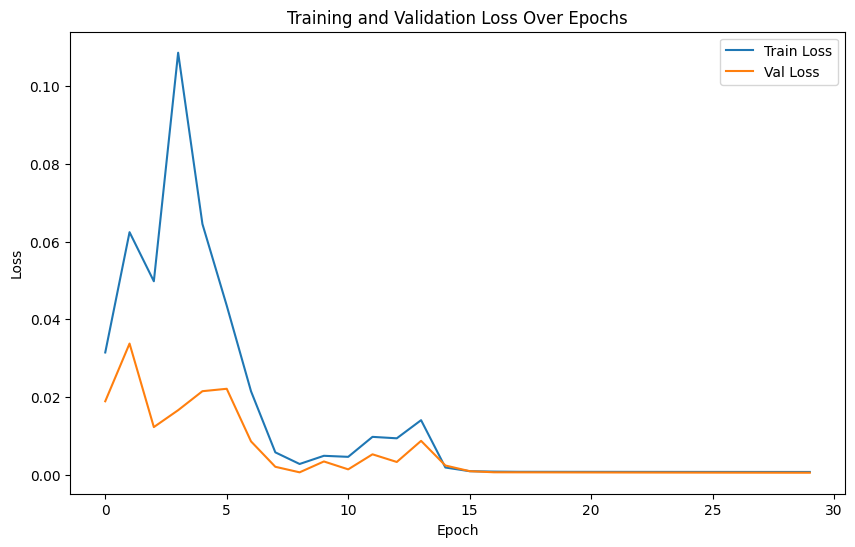

In [ ]:
# ---------------------------------------
# 9. Retrain Final Model with Best Hyperparams
# ---------------------------------------
best_params = study.best_params
model = VanillaRNN(input_dim=len(features), hidden_dim=best_params['hidden_dim'], output_dim=len(features)).to(device)
criterion = AsymmetricLoss(ratio=best_params['asymmetric_ratio'])
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)

best_state, _, train_losses, val_losses = train_and_validate(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=30)
model.load_state_dict(best_state)

# Plot training vs validation loss to check for overfitting
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Test MSE: 86.5652, RMSE: 9.3040, MAE: 6.9719


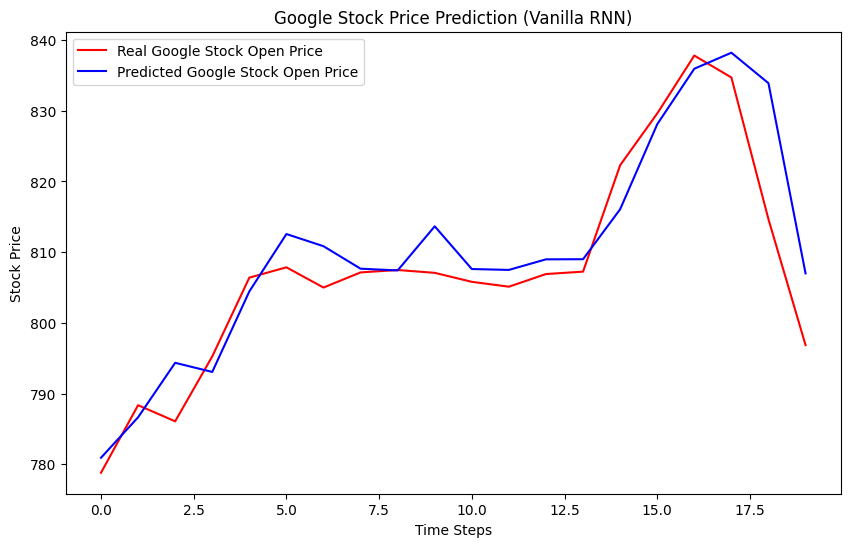

In [ ]:
# ---------------------------------------
# 10. Evaluate on Test Set
# ---------------------------------------
# Prepare test data
total_data = np.concatenate((training_set, test_set), axis=0)
inputs = total_data[len(total_data)-len(test_set)-N:]
inputs_scaled = scaler.transform(inputs)

X_test = []
for i in range(N, len(inputs_scaled)):
    X_test.append(inputs_scaled[i-N:i, :])
X_test = np.array(X_test)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    predicted_stock_price = model(X_test_torch).cpu().numpy()

predicted_stock_price = scaler.inverse_transform(predicted_stock_price.reshape(-1, len(features)))
real_prices = test_data[features].values

# Compute Evaluation Metrics
mse = mean_squared_error(real_prices[:len(predicted_stock_price), :], predicted_stock_price)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_prices[:len(predicted_stock_price), :], predicted_stock_price)
print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# Focus on 'Open' price for visualization
real_open_price = real_prices[:len(predicted_stock_price), 0]
predicted_open_price = predicted_stock_price[:, 0]

# Plot predicted vs real prices
plt.figure(figsize=(10,6))
plt.plot(real_open_price, color='red', label='Real Google Stock Open Price')
plt.plot(predicted_open_price, color='blue', label='Predicted Google Stock Open Price')
plt.title('Google Stock Price Prediction (Vanilla RNN)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

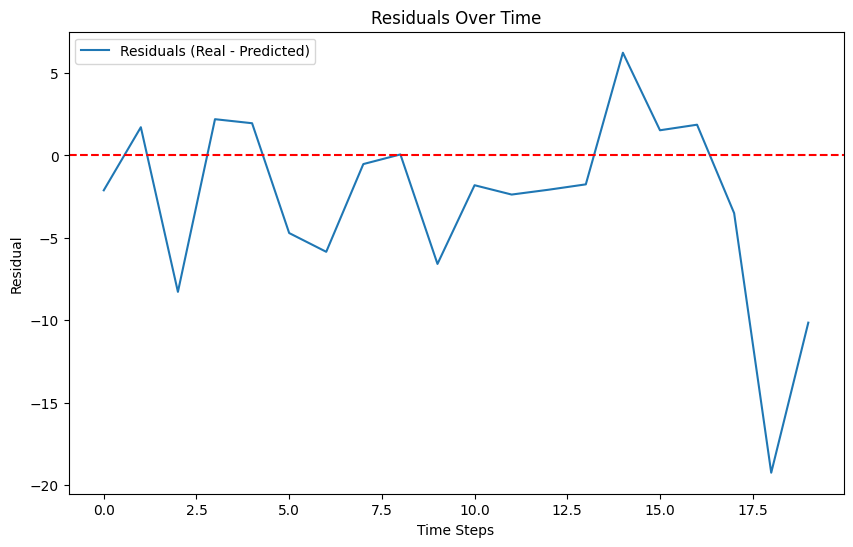

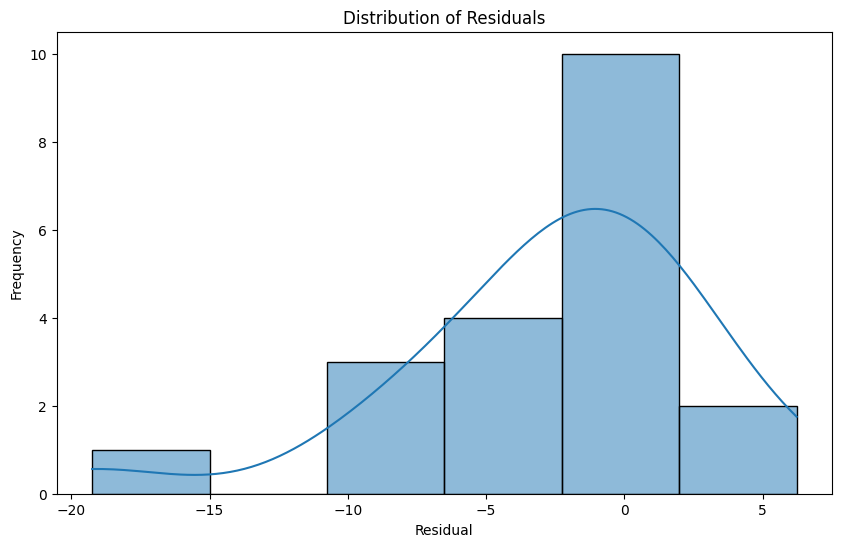

In [ ]:

# ---------------------------------------
# 11. Residual Analysis (Check for Systematic Bias)
# ---------------------------------------
residuals = real_open_price - predicted_open_price

# Plot residuals over time
plt.figure(figsize=(10,6))
plt.plot(residuals, label='Residuals (Real - Predicted)')
plt.title('Residuals Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Residual')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.show()

# Distribution of residuals
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()


